In [1]:
import warnings
warnings.filterwarnings("ignore")


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from tbats import TBATS


# Useful functions

It will be defined two functions that make the ADF and KPSS test execution more friendly.

In [3]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index=["Test Statistic", "p-value",
                                             "Lags Used", "Number of Observations Used"])
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"])
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)


# Data input and dataset exploratory analysis

## Dataset reading and exploration

In [4]:
file = "./expanded_dataset.csv"
data = pd.read_csv(file, sep=',', parse_dates=[0])
data


,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,2017-01-01 00:00:00,6.559000,73.800000,0.083000,0.051000,0.119000,34055.696200,16128.875380,20240.963860
1,2017-01-01 00:10:00,6.414000,74.500000,0.083000,0.070000,0.085000,29814.683540,19375.075990,20131.084340
2,2017-01-01 00:20:00,6.313000,74.500000,0.080000,0.062000,0.100000,29128.101270,19006.686930,19668.433730
3,2017-01-01 00:30:00,6.121000,75.000000,0.083000,0.091000,0.096000,28228.860760,18361.094220,18899.277110
4,2017-01-01 00:40:00,5.921000,75.700000,0.081000,0.048000,0.085000,27335.696200,17872.340430,18442.409640
...,...,...,...,...,...,...,...,...,...
104827,2018-12-29 23:10:00,7.060700,72.005969,0.076230,-4.023478,3.534700,31018.769888,26724.773464,14792.110257
104828,2018-12-29 23:20:00,6.959632,72.066226,0.072165,0.207339,-1.486588,30423.954944,26206.261514,14392.690950
104829,2018-12-29 23:30:00,6.997115,72.680981,0.175463,1.804606,2.061184,29645.071662,25377.148519,13838.338513
104830,2018-12-29 23:40:00,6.908843,73.155584,-0.004116,2.225365,-2.339974,28858.070425,24637.427282,13504.322200


In [5]:
print('Data types:\n', data.dtypes)


Data types:
 Datetime                  datetime64[ns]
Temperature                      float64
Humidity                         float64
WindSpeed                        float64
GeneralDiffuseFlows              float64
DiffuseFlows                     float64
PowerConsumption_Zone1           float64
PowerConsumption_Zone2           float64
PowerConsumption_Zone3           float64
dtype: object


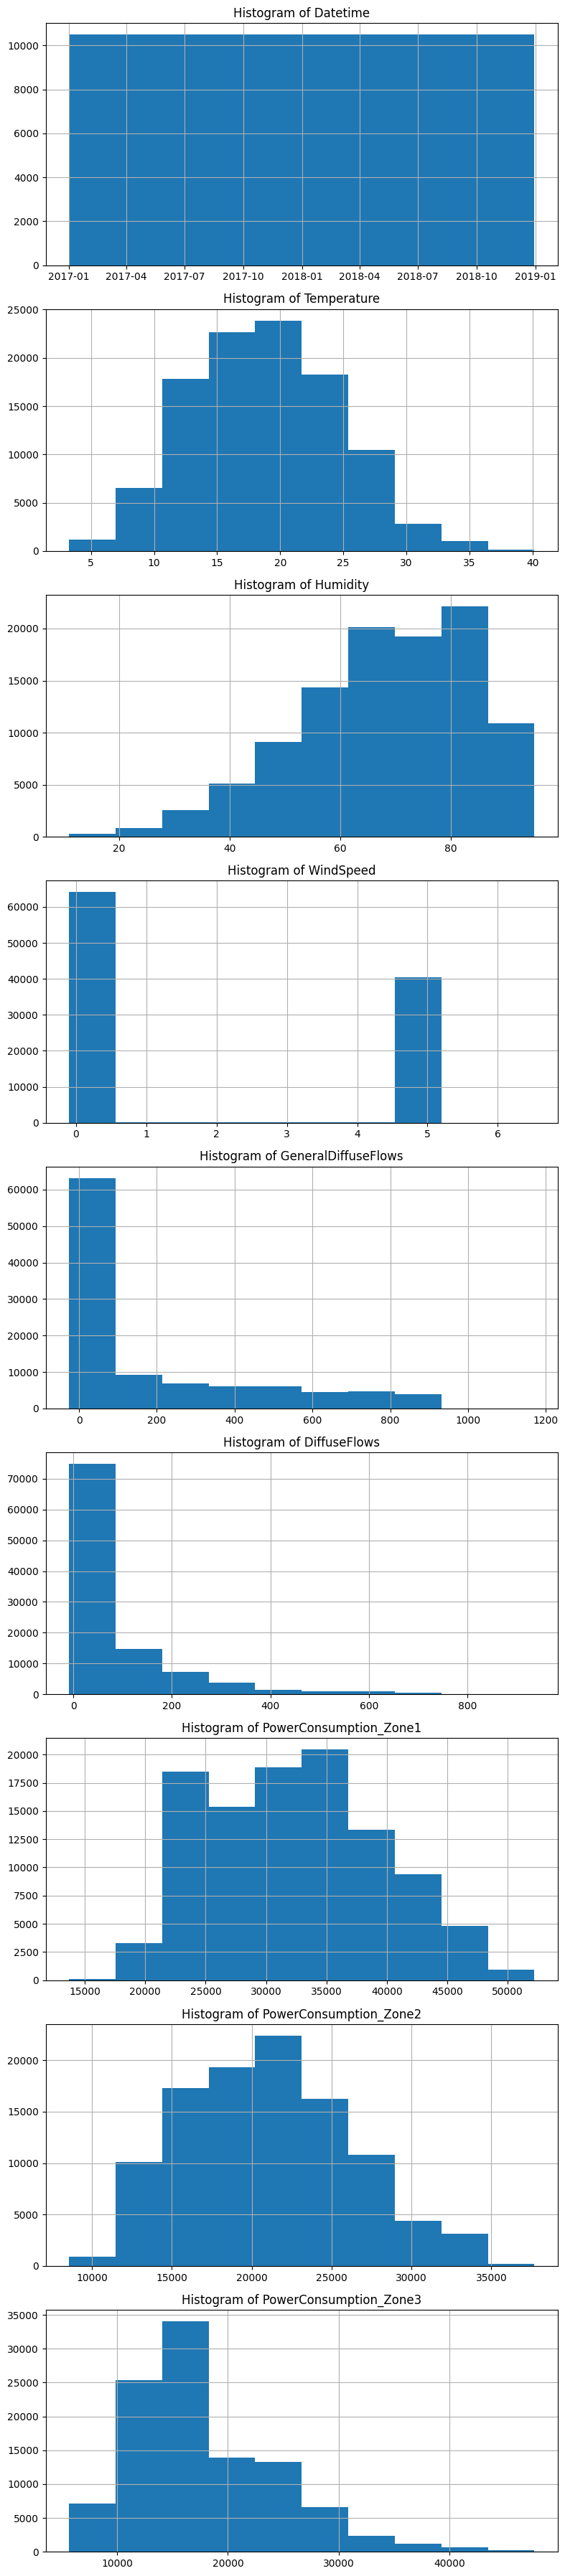

In [6]:
fig, axes = plt.subplots(nrows=len(data.columns), ncols=1, figsize=(8, len(data.columns) * 4))

for i, column in enumerate(data.columns):
    data[column].hist(ax=axes[i])
    axes[i].set_title(f'Histogram of {column}')

plt.tight_layout()
plt.show()


## Time series setting up

In this notebook only "Zone 1" data will be analyzed, so "Datetime" column is the index and "PwerConsumption_Zone1" column is time series values.

In [7]:
powerZ1 = pd.Series(data=data['PowerConsumption_Zone1'].values, index=data['Datetime'].values)
powerZ1


2017-01-01 00:00:00    34055.696200
2017-01-01 00:10:00    29814.683540
2017-01-01 00:20:00    29128.101270
2017-01-01 00:30:00    28228.860760
2017-01-01 00:40:00    27335.696200
                           ...     
2018-12-29 23:10:00    31018.769888
2018-12-29 23:20:00    30423.954944
2018-12-29 23:30:00    29645.071662
2018-12-29 23:40:00    28858.070425
2018-12-29 23:50:00    28166.170838
Length: 104832, dtype: float64

# Time series exploratory analysis

This stage includes the management of missing values, visualization, correlation functions analysis, stationarity and decomposition.

## Missing values

In [8]:
print('Index frequency:', pd.infer_freq(powerZ1.index)) #https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
print('Number of missing values:', powerZ1.isnull().sum())


Index frequency: 10min
Number of missing values: 0


As it's shown, this time series doesn't contain missing values, nor in the index nor in the values.

## Visualization

Graphics of the whole time series and of the last month portion are shown below. In them it's possible to see two seasonalities of the time series: daily and weekly.

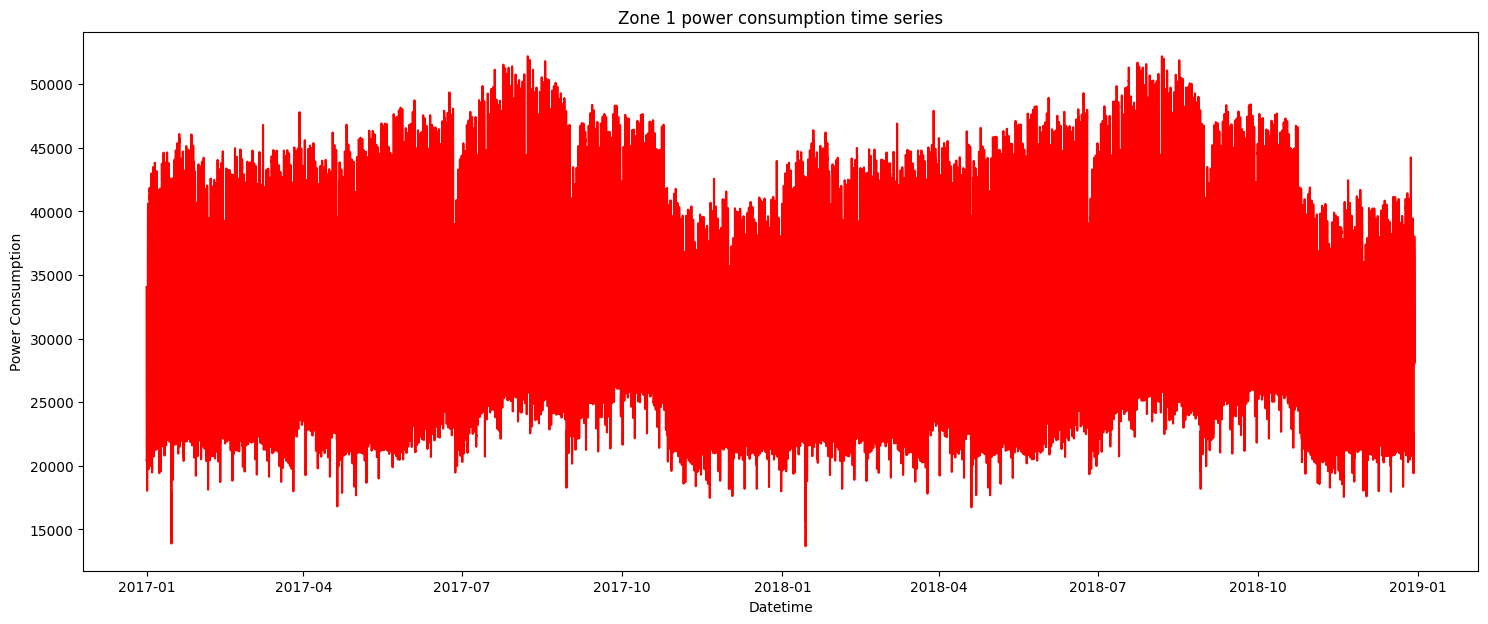

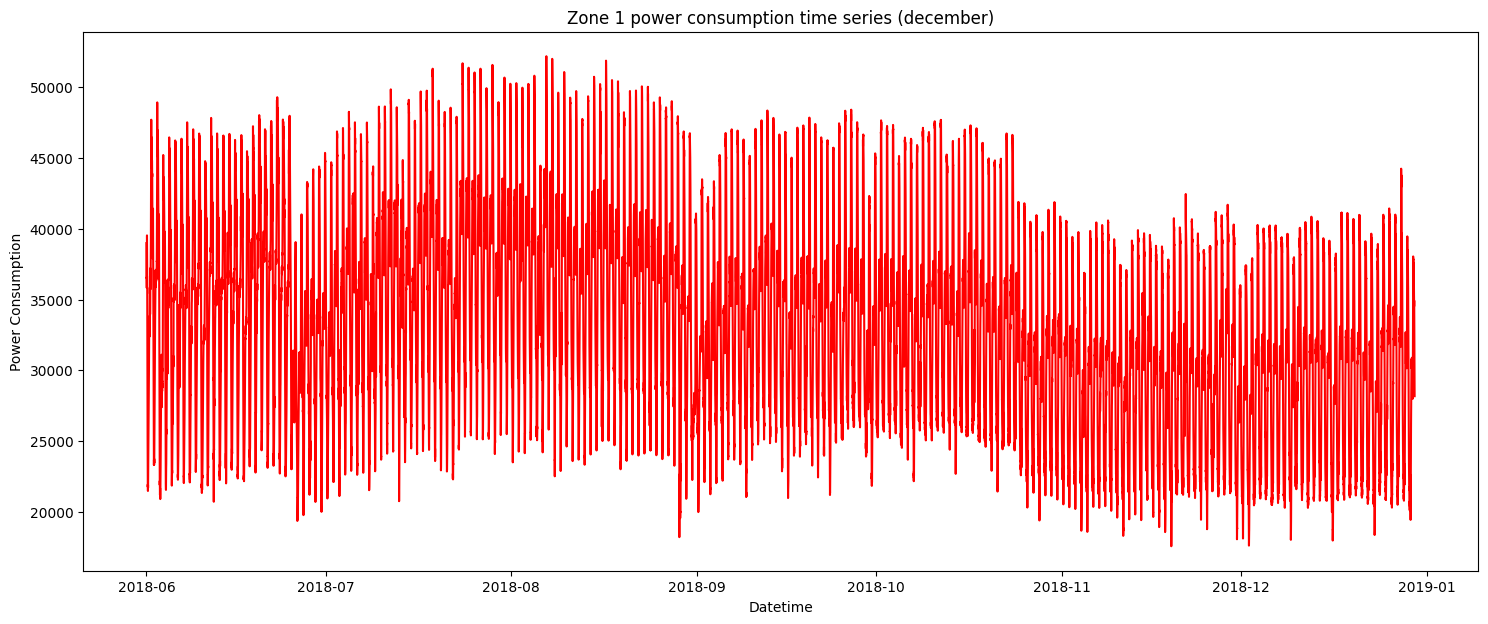

In [9]:
plt.figure(figsize=(18,7))
plt.plot(powerZ1, linestyle='-', color='red')
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Zone 1 power consumption time series')
plt.show()

plt.figure(figsize=(18,7))
plt.plot(powerZ1['2018-06-01 00:00:00':], linestyle='-', color='red')
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Zone 1 power consumption time series (december)')
plt.show()


In [10]:
import plotly.graph_objects as go

# Filter the data for the specified date range
filtered_data = powerZ1['2018-12-01 00:00:00':]

# Create the figure
fig = go.Figure()

# Add the trace
fig.add_trace(go.Scatter(x=filtered_data.index, y=filtered_data, mode='lines', line=dict(color='red')))

# Update the layout
fig.update_layout(
    title='Zone 1 power consumption time series (June)',
    xaxis_title='Datetime',
    yaxis_title='Power Consumption',
    width=1800,
    height=700
)

# Show the figure
fig.show()


SARIMA model is not capable of forecast time series with multiple seasonality, due to that and in order to reduce computational runtime, only last week of data will be analyzed with this model.

In [11]:
powerZ1_dec = powerZ1['2018-06-01 00:00:00':]


## Autocorrelation analysis

The 144 lags seasonality (corresponding to one day) and the non-stationarity of the time series are shown below:

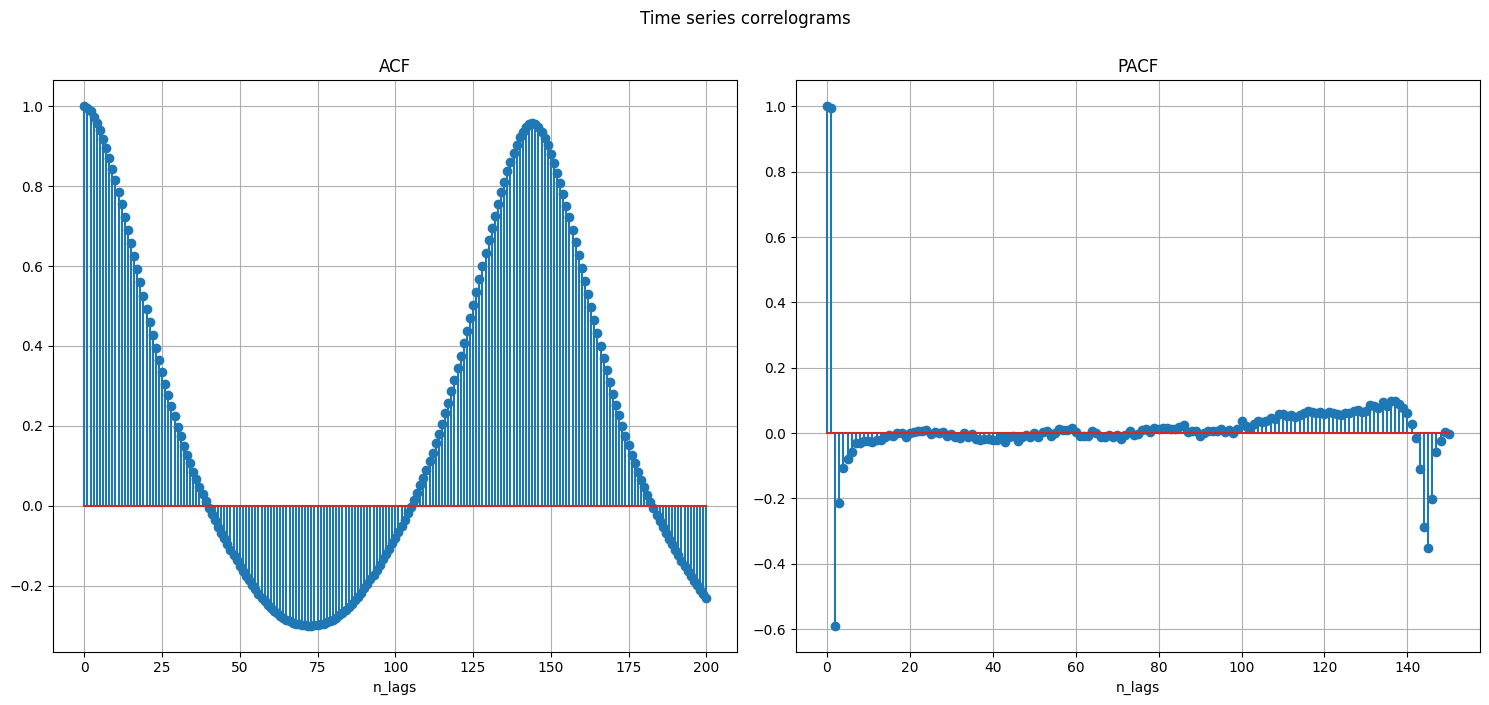

In [12]:
fas = sm.tsa.acf(powerZ1_dec, nlags=200)
fap = sm.tsa.pacf(powerZ1_dec, nlags=150) 

fig, axs = plt.subplots(1, 2, figsize=(15,7))
fig.suptitle('Time series correlograms', y=1)
axs[0].stem(fas)
axs[0].set_title('ACF')
axs[0].set_xlabel('n_lags')
axs[0].grid(True)
axs[1].stem(fap)
axs[1].set_title('PACF')
axs[1].set_xlabel('n_lags')
axs[1].grid(True)
plt.tight_layout()
plt.show()


## Moving average and standard devation

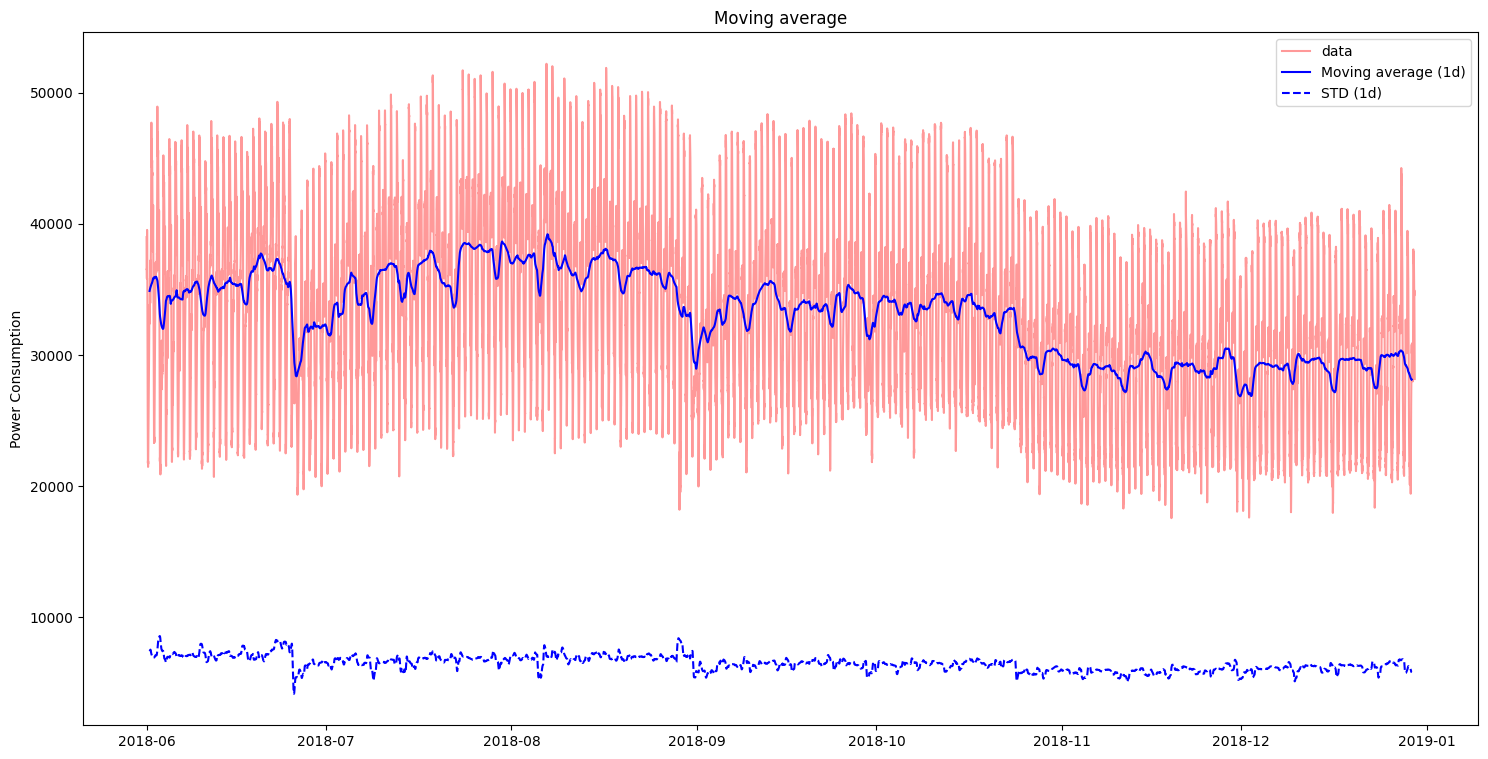

In [13]:
MMd = powerZ1_dec.rolling(144, center=True).mean()
STDd = powerZ1_dec.rolling(144, center=True).std()

plt.figure(figsize=(18,9))
plt.plot(powerZ1_dec, linestyle='-', color='red', alpha=0.4, label='data')
plt.plot(MMd, linestyle='-', color='b', label='Moving average (1d)')
plt.plot(STDd, linestyle='--', color='b', label='STD (1d)')
plt.ylabel('Power Consumption')
plt.title('Moving average', y=1)
plt.legend()
plt.show()


## Stationarity tests

In [14]:
adf_test(powerZ1_dec)
print('\nDifferentiations needed according to ADF:', pm.arima.utils.ndiffs(powerZ1_dec, test='adf'))
print('\n')
kpss_test(powerZ1_dec)
print('\nDifferentiations needed according to KPSS:', pm.arima.utils.ndiffs(powerZ1_dec, test='kpss'))


Results of Dickey-Fuller Test:
Test Statistic                   -24.970606
p-value                            0.000000
Lags Used                         48.000000
Number of Observations Used    30479.000000
Critical Value (1%)               -3.430565
Critical Value (5%)               -2.861635
Critical Value (10%)              -2.566820
dtype: float64

Differentiations needed according to ADF: 0


Results of KPSS Test:
Test Statistic           13.469016
p-value                   0.010000
Lags Used                98.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Differentiations needed according to KPSS: 1


C:\Users\vansh\AppData\Local\Temp\ipykernel_15288\1947440445.py:12: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




According to ADF & KPSS tests and the moving average graphic, the time series is stationary. But, in the other hand, there is a lot of evidence that it isn't: the time serie has seasonality, and the correlograms clearly are not similar to a white noise correlogram (moreover, PACF has values greater than 1!).

## Decomposition

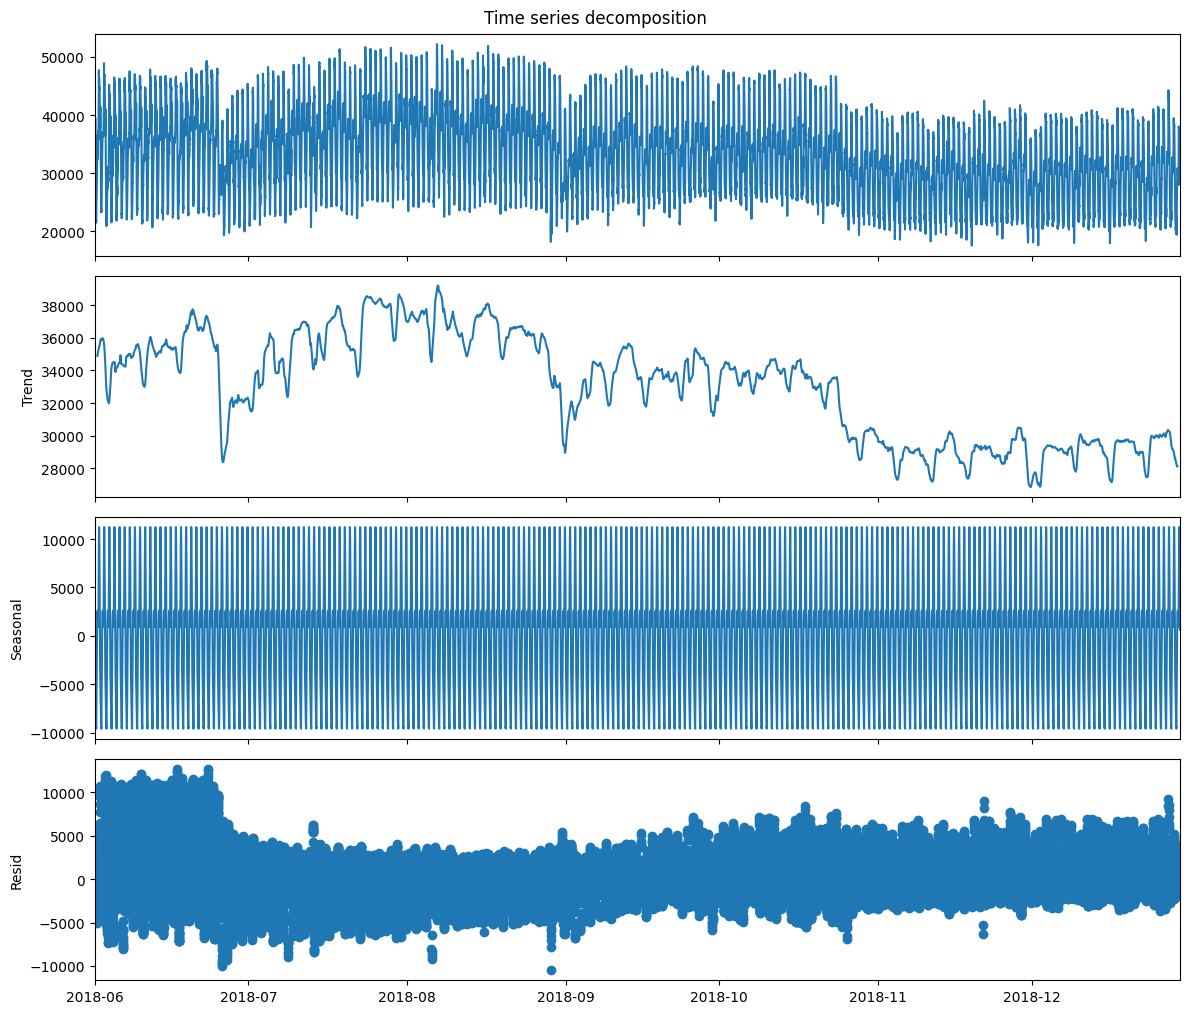

In [15]:
descomposicion_d = seasonal_decompose(powerZ1_dec, model='aditive', period=144)

plt.rcParams.update({'figure.figsize': (12,10)})
descomposicion_d.plot().suptitle('Time series decomposition', y=1.01)
plt.show()


# SARIMA analysis

## SARIMA orders setting up

One way to set up the orders of the model is running an "auto-ARIMA" (computationally expensive).

In [16]:
search_model = pm.arima.auto_arima(powerZ1_dec,
                                   start_p=1, start_q=1, d=1,
                                   max_p=7, max_q=7, max_d=5,
                                   max_order=None,
                                   m=144,
                                   seasonal=False,
                                   test='adf',
                                   n_jobs=-1,
                                   trace=True,
                                   error_action='ignore')


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=467820.617, Time=4.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=482109.990, Time=0.66 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=469496.163, Time=2.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=474153.916, Time=7.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=482107.999, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=467774.644, Time=7.52 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=468216.308, Time=3.65 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=467773.202, Time=13.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=467941.874, Time=3.93 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=467771.940, Time=19.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=467825.250, Time=5.77 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=467772.345, Time=30.73 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=467774.194, Time=20.76 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=467773.441, Time=12.46 sec


In [32]:
import pickle
with open('search_arima_model_manual.pkl', 'wb') as pkl_file:
    pickle.dump(search_model, pkl_file)


Another way is taking the auto-ARIMA results just a suggestion and making use of the exploratory analysis made previously. Consider the following "rules".

* s: time series seasonality in number of lags (see ACF graph).
* d and D: Differentiate the time series until it seems to be stationary (white noise).
* p: First lag with PACF value (nearly) zero.
* q: First lag with ACF value (nearly) zero.
* P: P>0 if ACF>0 at lag=s; else P=0.
* Q: Q>0 if ACF<0 at lag=s; else Q=0.

These rules aren't determinant, and different models can be tried in order to minimize some statistic criterion (AIC, BIC or HQIC).

We already know the time series seasonality, so let's see the number of differentiations needed to make the time series (seem to be) stationary which it is proven by the correlograms.

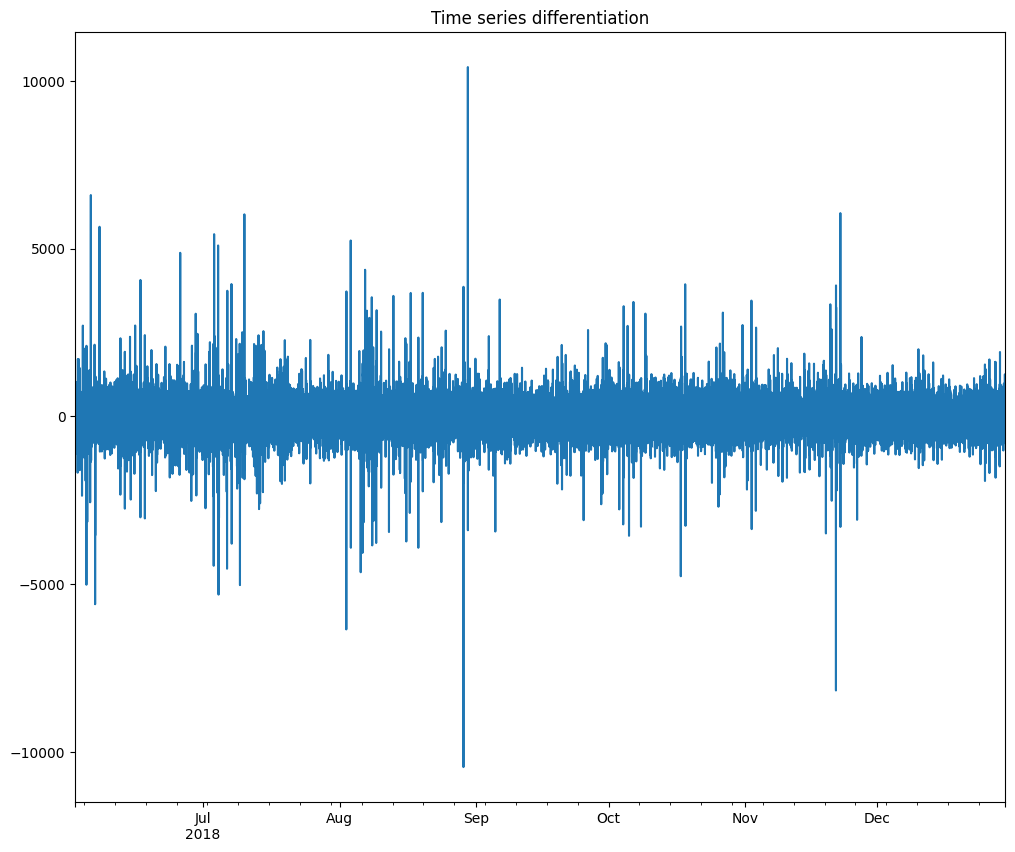

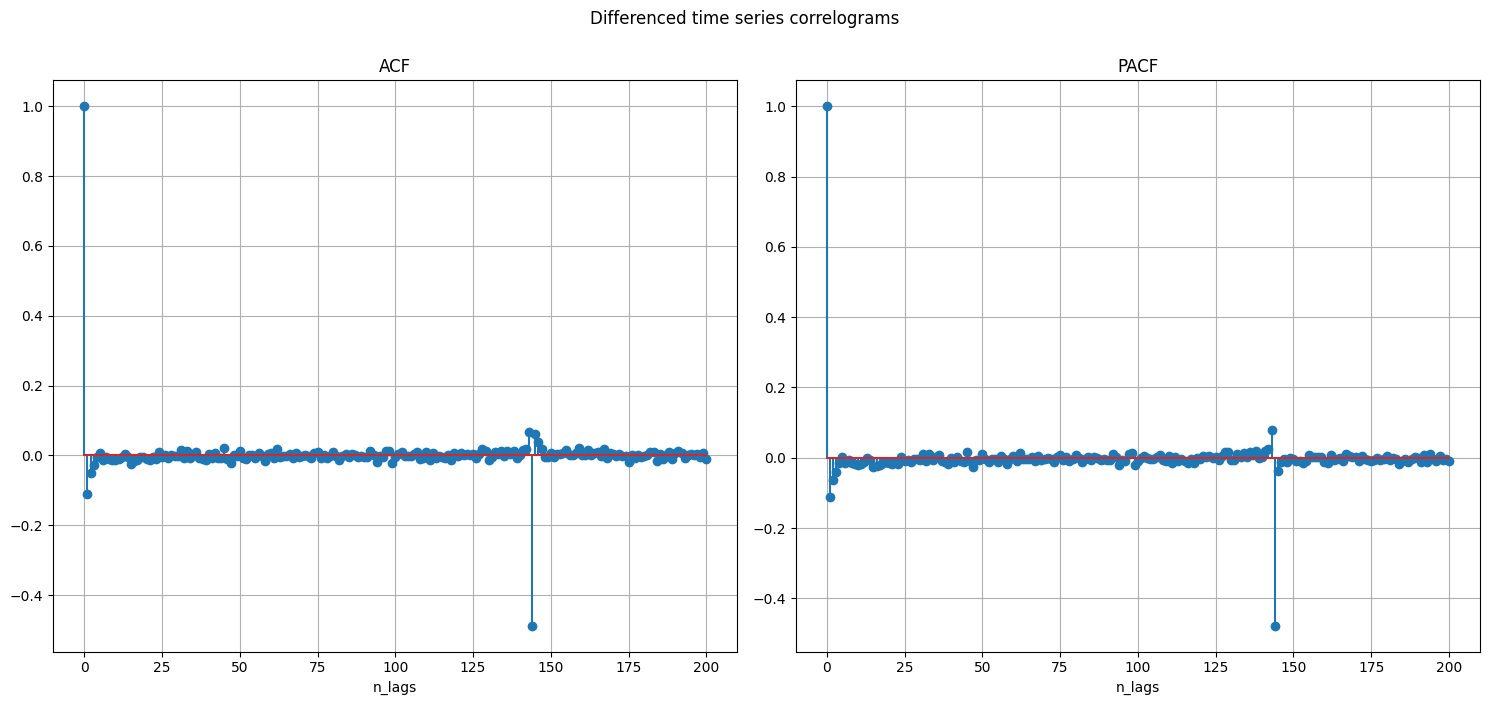

In [18]:
dif = sm.tsa.statespace.tools.diff(powerZ1_dec, k_diff=1, k_seasonal_diff=1, seasonal_periods=144)

dif.plot()
plt.title('Time series differentiation')
plt.show()

fas_dif = sm.tsa.acf(dif, nlags=200)
fap_dif = sm.tsa.pacf(dif, nlags=200)

fig, axs = plt.subplots(1, 2, figsize=(15,7))
fig.suptitle('Differenced time series correlograms', y=1)
axs[0].stem(fas_dif)
axs[0].set_title('ACF')
axs[0].set_xlabel('n_lags')
axs[0].grid(True)
axs[1].stem(fap_dif)
axs[1].set_title('PACF')
axs[1].set_xlabel('n_lags')
axs[1].grid(True)
plt.tight_layout()
plt.show()


The following orders are proposed and they can be adjusted until the model achieve good results.

In [17]:
s = 4
p = 1
q = 1
d = 0
P = 0
Q = 1
D = 1


## Train and test datasets

In [18]:
train = powerZ1_dec[:'2018-10-28 23:50:00']
test = powerZ1_dec['2018-10-29 00:00:00':]


## Model, training, forcasting and evaluation

In [19]:
model = ARIMA(train, order=(p,d,q), seasonal_order=(P,D,Q,s))


C:\Users\vansh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency 10min will be used.

C:\Users\vansh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency 10min will be used.

C:\Users\vansh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency 10min will be used.



In [20]:
model = model.fit(low_memory=False)


In [23]:
print('SARIMA model summary\n', model.summary())


SARIMA model summary
                                      SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                21600
Model:             ARIMA(2, 1, 2)x(0, 1, [1], 6)   Log Likelihood             -167658.872
Date:                           Mon, 03 Feb 2025   AIC                         335329.744
Time:                                   20:37:10   BIC                         335377.625
Sample:                               06-01-2018   HQIC                        335345.351
                                    - 10-28-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9782      0.012    160.065      0.000       1.954       2.002
ar.L2         -0.9793

In [21]:
pred = model.get_prediction(end=len(powerZ1_dec)-1)
pred_train = pred.predicted_mean[:'2017-12-28 23:50:00']
pred_test = pred.predicted_mean['2017-12-29 00:00:00':]
pred_conf_int = pred.conf_int()


In [22]:

distinct_counts = pred_test.nunique()

print(distinct_counts)


30528


In [ ]:

err = powerZ1_dec - pred.predicted_mean

plt.figure(figsize=(18,9))
plt.plot(train, color='red', linestyle='-', label='Train')
plt.plot(test, color='indianred', linestyle='-', label='Test')
plt.plot(pred_train, color='teal', linestyle='-', label='Train pred')
plt.plot(pred_test, color='turquoise', linestyle='-', label='Test pred')
plt.fill_between(pred_conf_int.index, pred_conf_int['lower y'], pred_conf_int['upper y'], color='k', alpha=0.1, label='conf. int.', edgecolor=None)
#plt.ylim(-50, 350)
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Power consumption SARIMA forecast')
plt.legend()
plt.show()

fig, (err1, err2) = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle('SARIMA errors')
err1.plot(err, 'bo')
err1.set_ylim([-7000,7000])
err1.set_xlabel('Date')
err1.set_ylabel('Power Consumption')
sb.histplot(err, bins=13, kde=True, ax=err2, binrange=(-5000,5000))
err2.set_xlabel('Power Consumption')
plt.tight_layout()
plt.show()


The model built does a good job forecasting the test dataset. The errors have a normal distribution, except for the test prediction, which has a positive bias.

## Future prediction

If we are happy with these results, we can use the model in order to predict future values, which we haven't any information about. For that, it's convenient to train our model with all available data.

In [25]:
futuro = pd.date_range('2017-12-31 00:00:00', periods=288, freq='10T')
model = ARIMA(powerZ1_dec, order=(p,d,q), seasonal_order=(P,D,Q,s))
model = model.fit(low_memory=True)
print('SARIMA model summary\n', model.summary())


C:\Users\vansh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
C:\Users\vansh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
C:\Users\vansh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)


SARIMA model summary
                                      SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                30528
Model:             ARIMA(2, 1, 2)x(0, 1, [1], 6)   Log Likelihood             -235218.544
Date:                           Mon, 03 Feb 2025   AIC                         470449.088
Time:                                   20:40:11   BIC                         470499.045
Sample:                               06-01-2018   HQIC                        470465.104
                                    - 12-29-2018                                         
Covariance Type:                          approx                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9925        nan        nan        nan         nan         nan
ar.L2         -0.9927

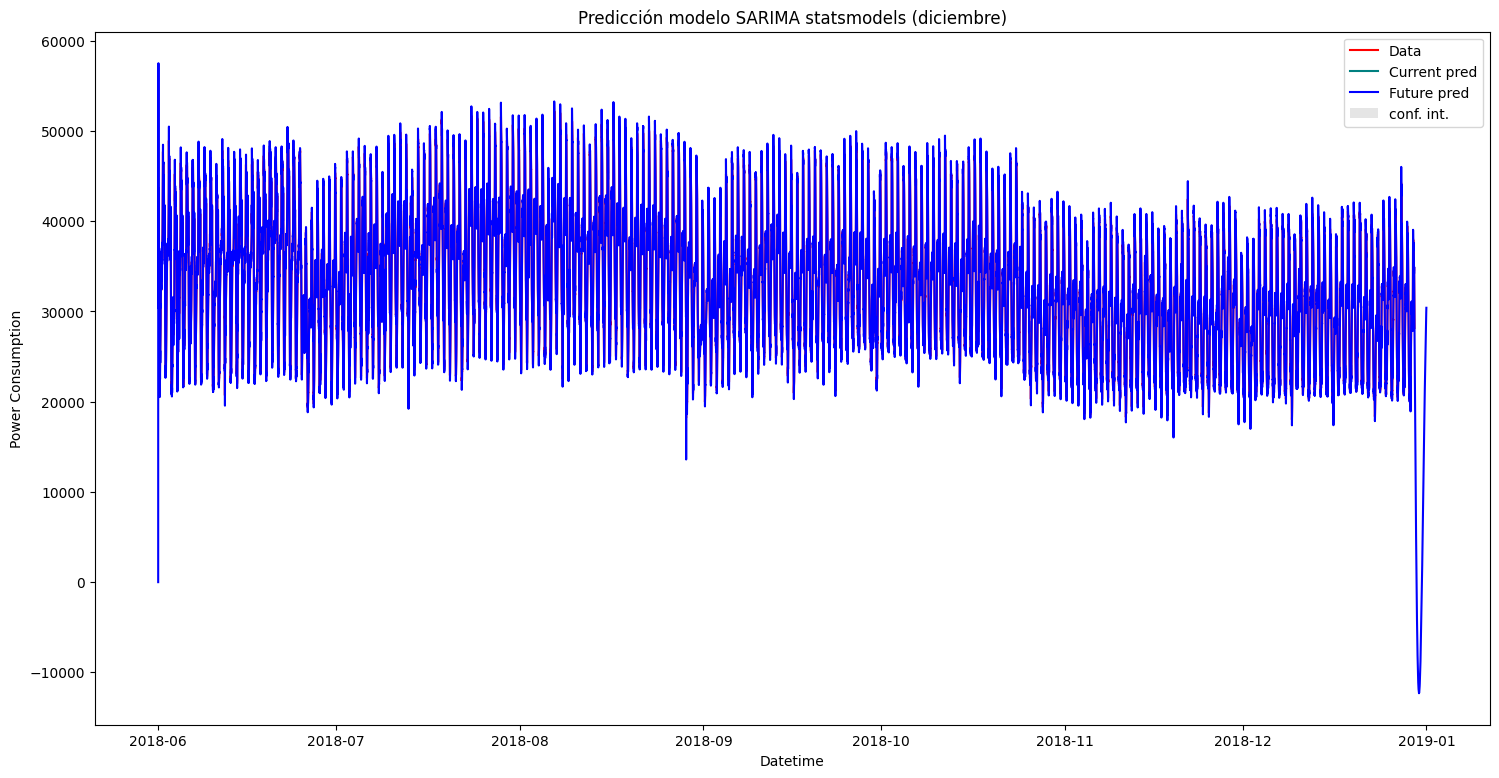

In [26]:
pred = model.get_prediction(end=len(powerZ1_dec)+len(futuro)-1)
pred_train = pred.predicted_mean[:'2017-12-30 23:50:00']
pred_futuro = pred.predicted_mean['2017-12-31 00:00:00':]
pred_conf_int = pred.conf_int()

plt.figure(figsize=(18,9))
plt.plot(powerZ1_dec, color='red', linestyle='-', label='Data')
plt.plot(pred_train, color='teal', linestyle='-', label='Current pred')
plt.plot(pred_futuro, color='b', linestyle='-', label='Future pred')
plt.fill_between(pred_conf_int.index, pred_conf_int['lower y'], pred_conf_int['upper y'], color='k', alpha=0.1, label='conf. int.', edgecolor=None)
#plt.ylim(-50, 350)
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Predicción modelo SARIMA statsmodels (diciembre)')
plt.legend()
plt.show()


# TBATS analysis

This model has a very simple implementation because the best model search is made by the algorithm itself. Additionaly, it has the extra advantage of allow the forecasting of time series with multiple seasonalities. For these reasons, the fitting time might be long, depending of the data size.

In the other hand, this model doesn't require so much RAM in the training time, so we can forecast the original whole time series. Before starting, let's check the seasonalities of the time series with the correlograms.

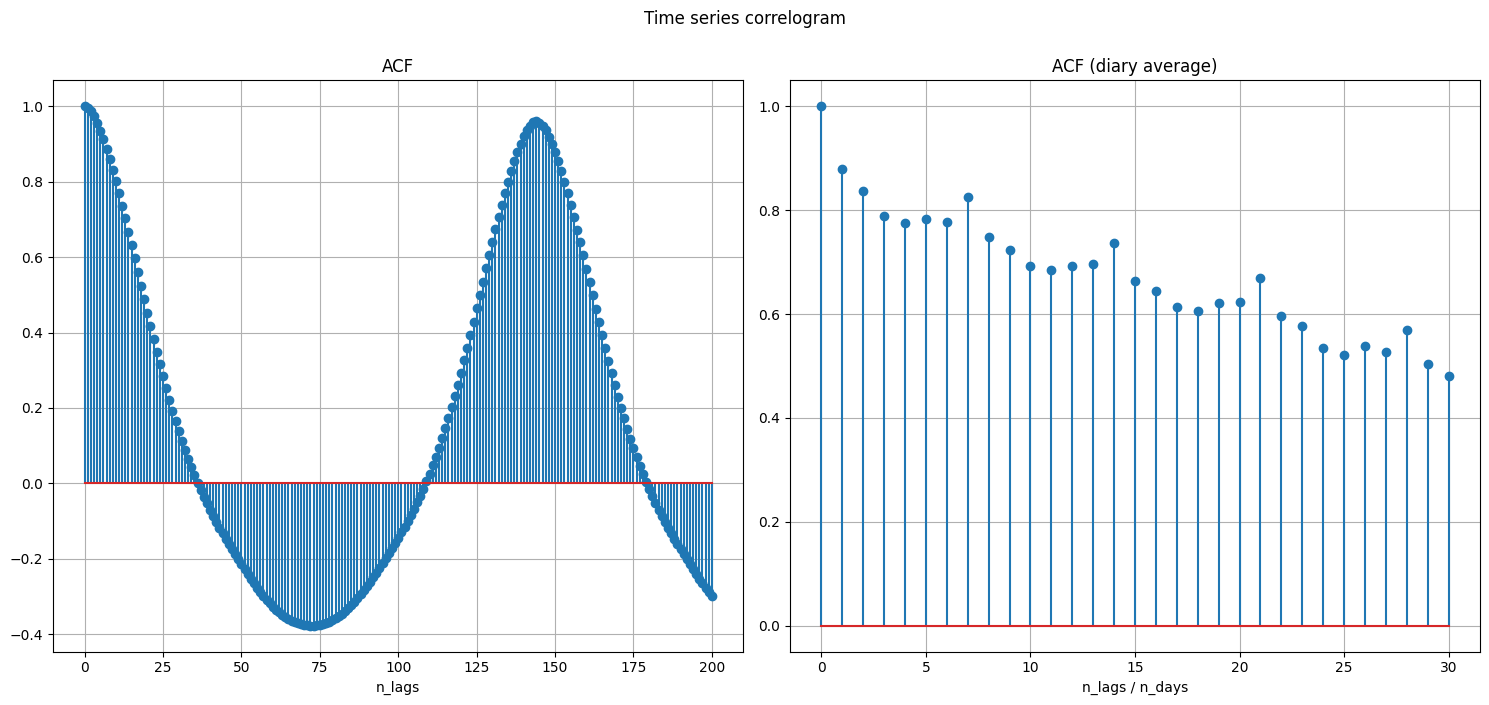

In [27]:
fas_d = sm.tsa.acf(powerZ1, nlags=200)
fas_s = sm.tsa.acf(powerZ1.resample('D').mean(), nlags=30)

fig, axs = plt.subplots(1, 2, figsize=(15,7))
fig.suptitle('Time series correlogram', y=1)
axs[0].stem(fas_d)
axs[0].set_title('ACF')
axs[0].set_xlabel('n_lags')
axs[0].grid(True)
axs[1].stem(fas_s)
axs[1].set_title('ACF (diary average)')
axs[1].set_xlabel('n_lags / n_days')
axs[1].grid(True)
plt.tight_layout()
plt.show()


As we see, the sime series has two seasonalities: daily and weekly, corresponding to 144 and 1008 lags respectively.

Now, let's build the model.

# required on windows for multi-processing,
# see https://docs.python.org/2/library/multiprocessing.html#windows
if __name__ == '__main__':
    #DATA
    file = "/home/mr-arthor/Desktop/Codes/CDAC_Project_Work/Topic_2/DataSet/powerconsumption.csv"
    data = pd.read_csv(file, sep=',', parse_dates=[0])
    
    powerZ1 = pd.Series(data=data['PowerConsumption_Zone1'].values, index=pd.to_datetime(data['Datetime'].values))

    train = powerZ1[:'2017-09-30 23:50:00']
    test = powerZ1['2017-10-01 00:00:00':]
    
    #MODEL
    estimator = TBATS(seasonal_periods=[144, 1008], use_trend=False)
    fitted_model = estimator.fit(train)
    print('TBATS model summary:\n', fitted_model.summary())
    
    pred_train = pd.Series(data=fitted_model.y_hat, index=train.index)
    
    pred_test, conf_test = fitted_model.forecast(steps=len(test), confidence_level=0.95)
    pred_test = pd.Series(data=pred_test, index=test.index)
    conf_test = pd.DataFrame(data={'lower_bound':conf_test['lower_bound'], 'upper_bound':conf_test['upper_bound']}, index=test.index)
    
    err_train = pd.Series(data=fitted_model.resid, index=train.index)
    err_test = test - pred_test
    err = pd.concat([err_train, err_test])


In [28]:
data = pd.read_csv(file, sep=',', parse_dates=[0])
    
powerZ1 = pd.Series(data=data['PowerConsumption_Zone1'].values, index=pd.to_datetime(data['Datetime'].values))

train = powerZ1[:'2018-09-30 23:50:00']
test = powerZ1['2018-10-01 00:00:00':]

#MODEL
estimator = TBATS(seasonal_periods=[144, 1008], use_trend=False)
fitted_model = estimator.fit(train)
print('TBATS model summary:\n', fitted_model.summary())

pred_train = pd.Series(data=fitted_model.y_hat, index=train.index)

pred_test, conf_test = fitted_model.forecast(steps=len(test), confidence_level=0.95)
pred_test = pd.Series(data=pred_test, index=test.index)
conf_test = pd.DataFrame(data={'lower_bound':conf_test['lower_bound'], 'upper_bound':conf_test['upper_bound']}, index=test.index)

err_train = pd.Series(data=fitted_model.resid, index=train.index)
err_test = test - pred_test
err = pd.concat([err_train, err_test])


TBATS model summary:
 Use Box-Cox: True
Use trend: False
Use damped trend: False
Seasonal periods: [ 144. 1008.]
Seasonal harmonics [8 1]
ARMA errors (p, q): (0, 0)
Box-Cox Lambda 0.671481
Smoothing (Alpha): 1.271734
Seasonal Parameters (Gamma): [-0.00309904  0.01191928  0.02062419 -0.02100035]
AR coefficients []
MA coefficients []
Seed vector [ 1.51535749e+03  1.28582735e+01  6.17957629e+01 -6.56701600e+01
 -2.09919306e+01  8.75937440e+00  3.42529215e+00 -2.92243184e+00
 -2.51244747e+00 -2.46083571e+02 -9.47870411e+01 -1.79261183e+01
 -1.19063090e+00  2.85050934e+00 -5.84395315e+00 -2.46137556e+00
  2.80835738e-01 -2.18467781e+01 -6.39298017e+00]

AIC 2169305.182425


In [33]:
with open('tbats__model.pkl', 'wb') as pkl_file:
    pickle.dump(fitted_model, pkl_file)


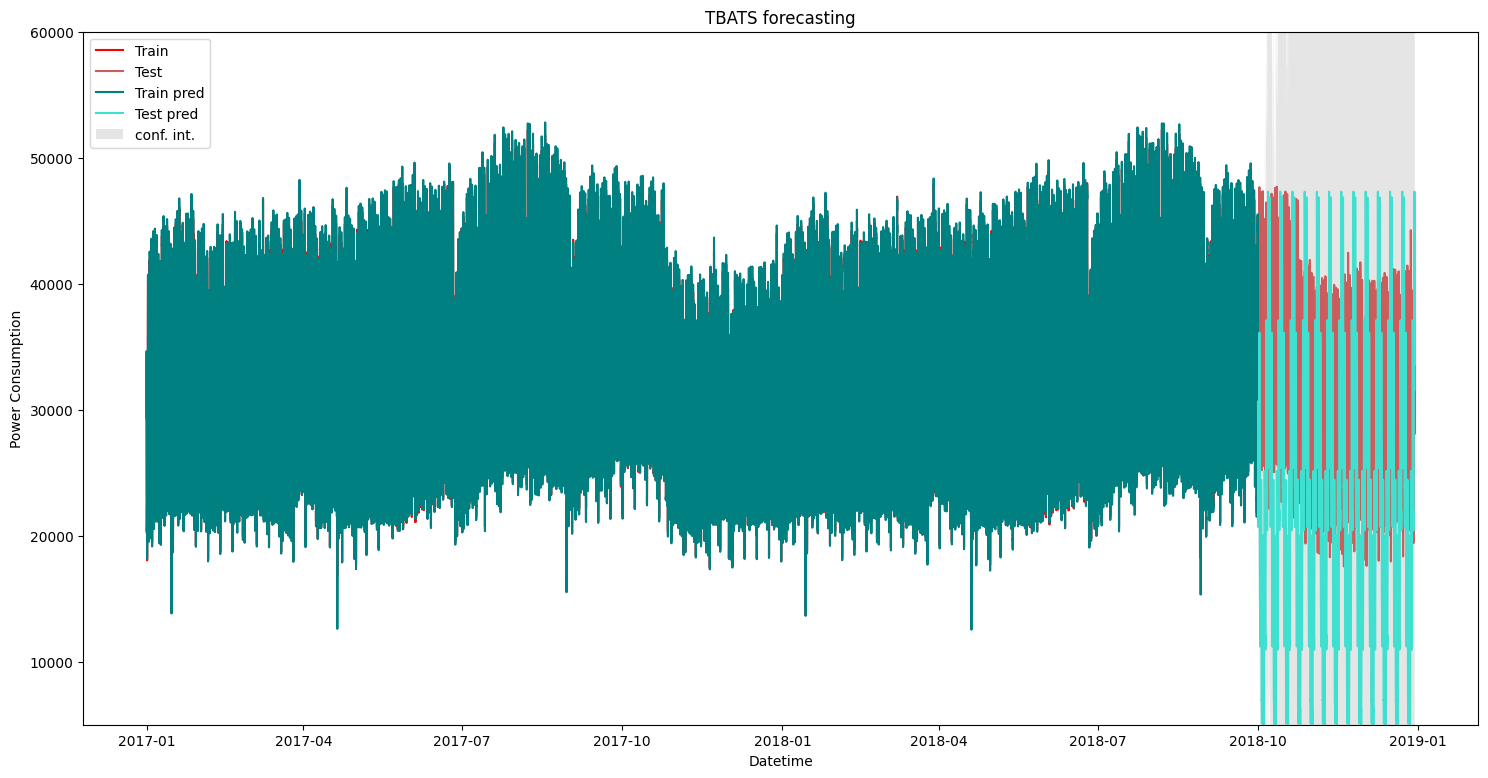

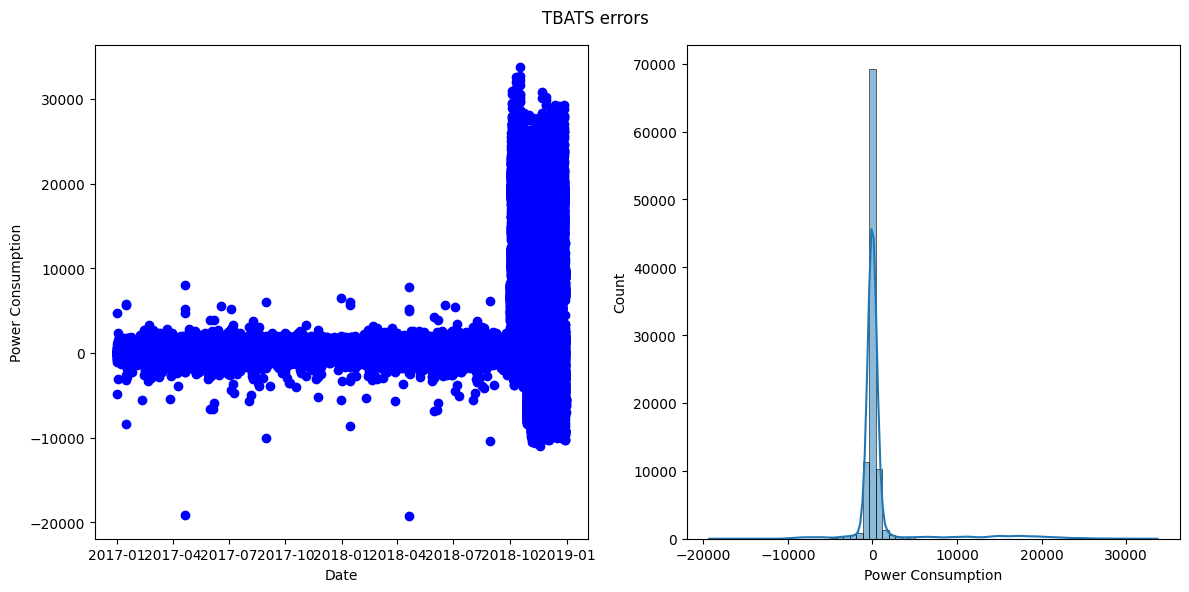

In [29]:
#Whole visualization
plt.figure(figsize=(18,9))
plt.plot(train, color='red', linestyle='-', label='Train')
plt.plot(test, color='indianred', linestyle='-', label='Test')
plt.plot(pred_train, color='teal', linestyle='-', label='Train pred')
plt.plot(pred_test, color='turquoise', linestyle='-', label='Test pred')
plt.fill_between(conf_test.index, conf_test['lower_bound'], conf_test['upper_bound'], color='k', alpha=0.1, label='conf. int.', edgecolor=None)
plt.ylim(5000, 60000)
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('TBATS forecasting')
plt.legend()
plt.show()

fig, (err1, err2) = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle('TBATS errors')
err1.plot(err, 'bo')
#err1.set_ylim([-7000,7000])
err1.set_xlabel('Date')
err1.set_ylabel('Power Consumption')
sb.histplot(err, bins=13, kde=True, ax=err2, binrange=(-5000,5000))
err2.set_xlabel('Power Consumption')
plt.tight_layout()
plt.show()


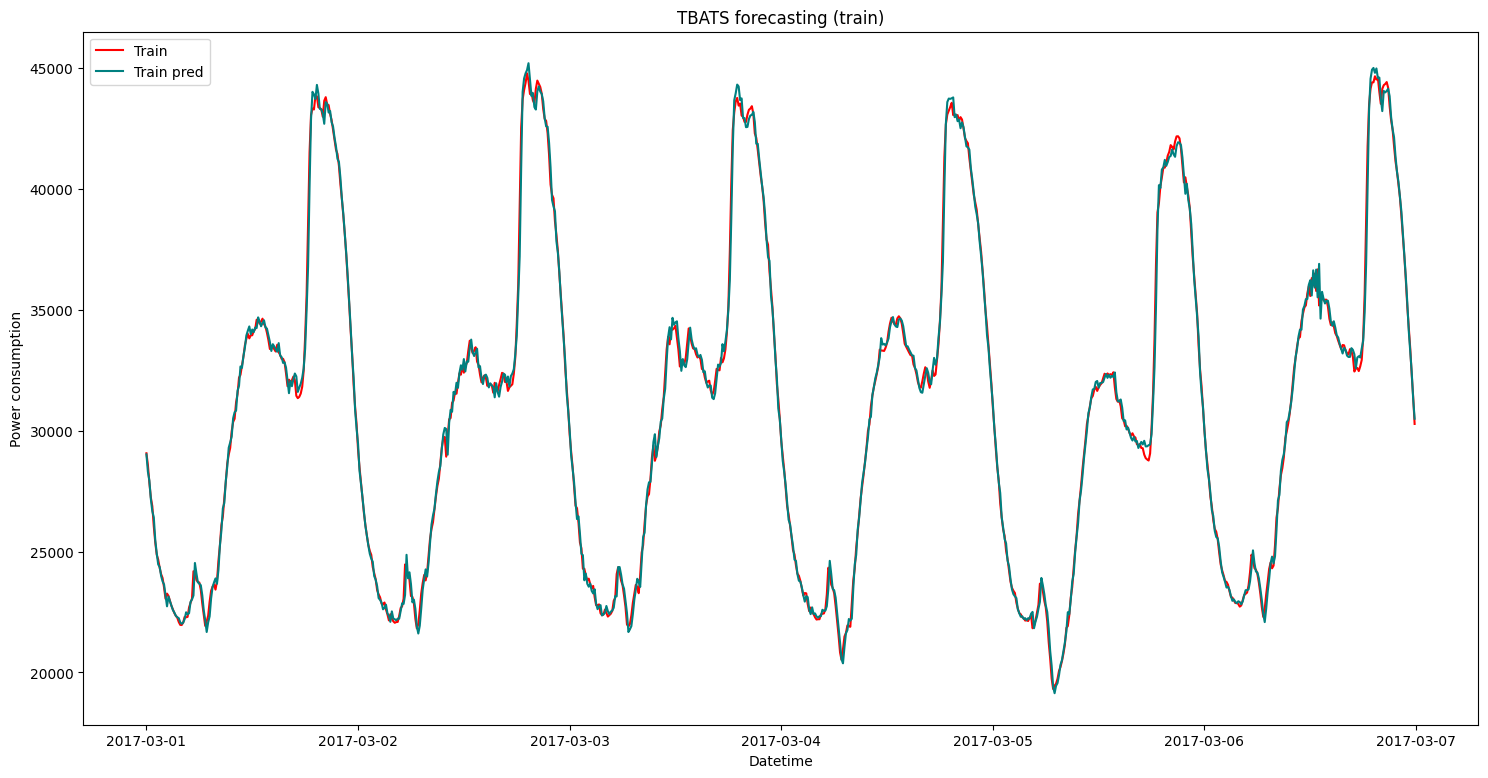

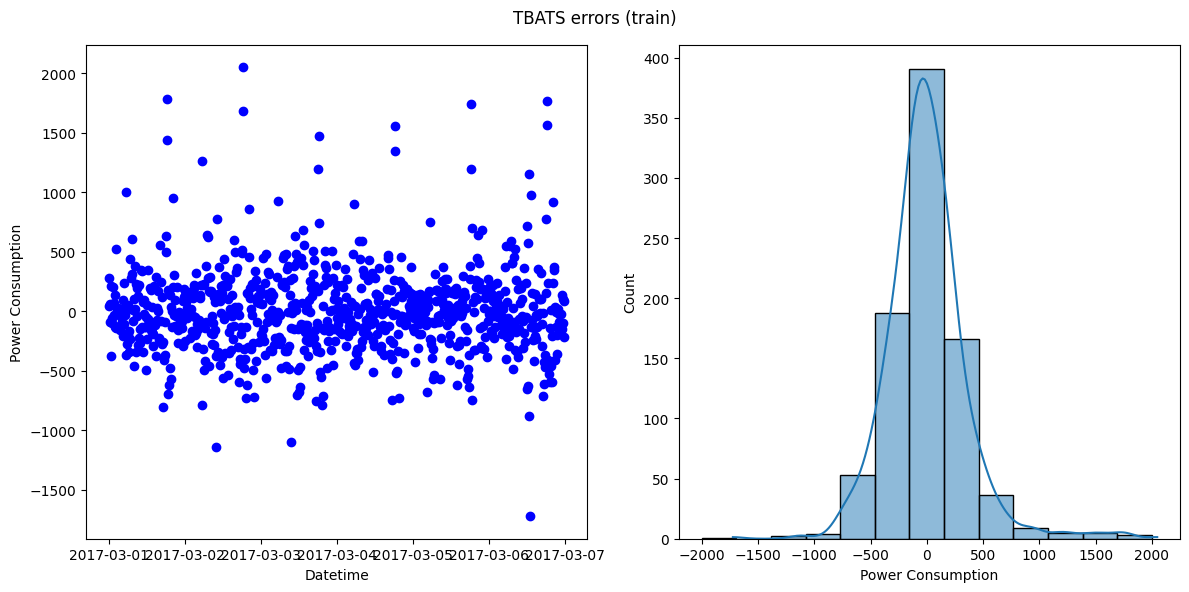

In [30]:
#Train dataset and forecasting visualization
plt.figure(figsize=(18,9))
plt.plot(train['2017-03-01 00:00:00':'2017-03-06 23:50:00'], color='red', linestyle='-', label='Train')
plt.plot(pred_train['2017-03-01 00:00:00':'2017-03-06 23:50:00'], color='teal', linestyle='-', label='Train pred')
#plt.ylim(-50, 350)
plt.xlabel('Datetime')
plt.ylabel('Power consumption')
plt.title('TBATS forecasting (train)')
plt.legend()
plt.show()

fig, (err1, err2) = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle('TBATS errors (train)')
err1.plot(err['2017-03-01 00:00:00':'2017-03-06 23:50:00'], 'bo')
err1.set_xlabel('Datetime')
err1.set_ylabel('Power Consumption')
sb.histplot(err['2017-03-01 00:00:00':'2017-03-06 23:50:00'], bins=13, kde=True, ax=err2, binrange=(-2000,2000))
err2.set_xlabel('Power Consumption')
plt.tight_layout()
plt.show()


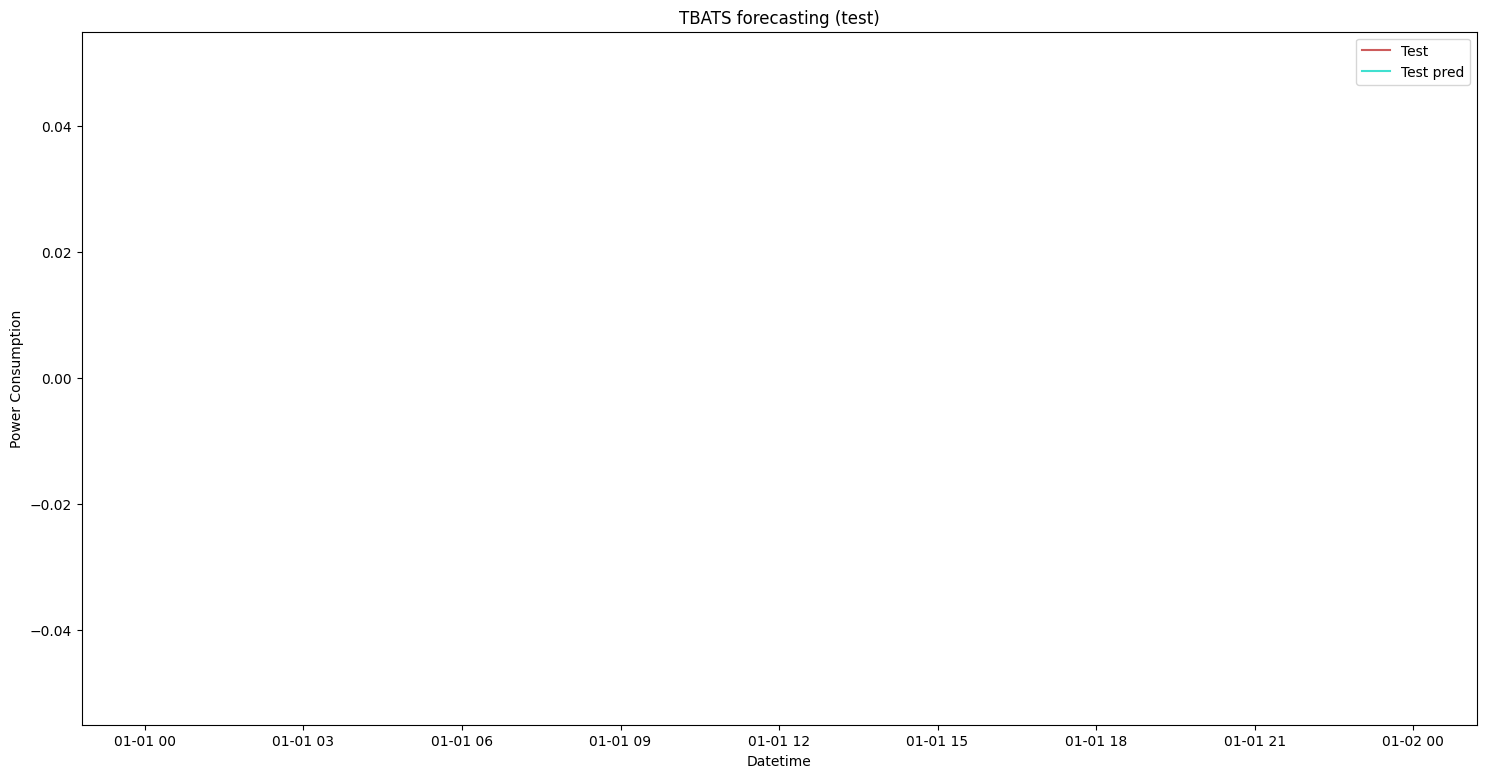

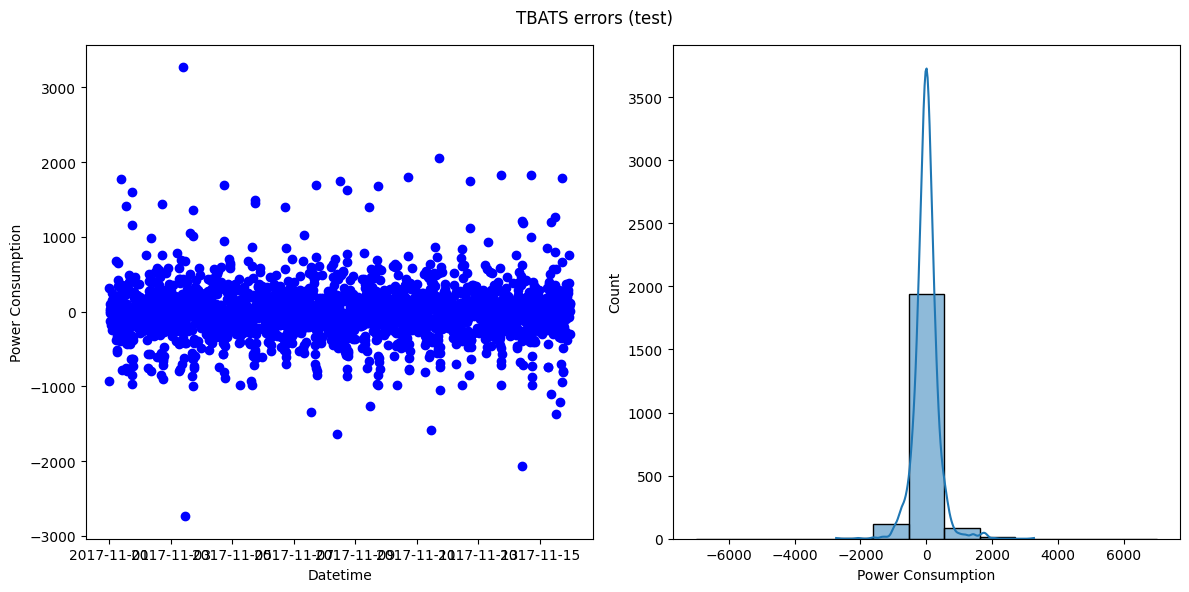

In [31]:
#Test dataset and forecasting visualization
plt.figure(figsize=(18,9))
plt.plot(test['2017-11-01 00:00:00':'2017-11-15 23:50:00'], color='indianred', linestyle='-', label='Test')
plt.plot(pred_test['2017-11-01 00:00:00':'2017-11-15 23:50:00'], color='turquoise', linestyle='-', label='Test pred')
#plt.ylim(-50, 250)
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('TBATS forecasting (test)')
plt.legend()
plt.show()

fig, (err1, err2) = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle('TBATS errors (test)')
err1.plot(err['2017-11-01 00:00:00':'2017-11-15 23:50:00'], 'bo')
err1.set_xlabel('Datetime')
err1.set_ylabel('Power Consumption')
sb.histplot(err['2017-11-01 00:00:00':'2017-11-15 23:50:00'], bins=13, kde=True, ax=err2, binrange=(-7000,7000))
err2.set_xlabel('Power Consumption')
plt.tight_layout()
plt.show()


As we see, this model is also good in forecasting the time series. Moreover, it reproduces the two time series seasonalities. Due to the time series non-constant trend over the 2017, the predicted values have a bias. The severity of that depends on the specific problem.

PS: I had to set the "use_trend" parameter to False for getting good results in test forecasting. Moreover, I ran this TBATS code in my local computer and I obtained different results. I mean, without setting any parameter previously (except for seasonal periods), the results are very good. After checking data, code and tbats version, I think that it's due to Python's version (3.7 in Kaggle; 3.9 in my laptop). Anyway, below I show the model summary obtained in my local computer:

> Use Box-Cox: True // 
Use trend: False // 
Use damped trend: False // 
Seasonal periods: [ 144. 1008.] // 
Seasonal harmonics [30 1] // 
ARMA errors (p, q): (1, 2) // 
Box-Cox Lambda 0.875635 // 
Smoothing (Alpha): 1.448806 // 
Seasonal Parameters (Gamma): [-3.84336972e-05 3.87355182e-05 8.28030210e-06
-4.53795097e-06] // 
AR coefficients [8.2803021e-06] // 
MA coefficients [-4.53795097e-06 1.78913033e-01] // 
Seed vector [ 9.55890677e+03 1.81918895e+02 5.96352067e+02 -5.87324239e+02
-2.39891871e+02 6.18267852e+01 6.28401684e+01 -1.87302179e+01
-4.40759917e+01 -1.84204110e+01 1.24081811e+01 2.00401356e+01
3.88063026e+00 -1.29623964e+01 -3.14908585e+00 6.02473760e+00
1.16615610e+01 -7.83426566e-01 -1.01213642e+01 -4.28691018e+00
3.73655683e+00 -6.57858618e-01 6.29010078e-01 6.69939116e+00
-8.65263328e+00 -3.84675483e+00 4.71055245e+00 4.21797712e+00
-3.94302018e+00 -1.67309331e+00 5.47165788e-01 -2.11370302e+03
-8.42461439e+02 -2.07688861e+02 -6.07789348e+00 4.91464392e+01
-5.68716274e+01 -3.94907936e+01 1.33766645e+00 1.23832070e+01
-9.42067397e+00 7.92157780e+00 8.45583795e+00 4.27741882e+00
-2.13948204e+00 5.63955305e+00 -2.00542930e+00 -2.65727733e-02
-1.77233906e+00 -3.05341825e-01 1.35004366e+00 -2.69823910e-01
-4.83639141e+00 -2.67087565e+00 5.60666125e+00 2.12342271e+00
-6.01275688e-01 4.31869336e-01 -3.61082311e+00 1.49146496e+00
-5.52610017e-01 -1.89232054e+02 -7.29398314e+01 0.00000000e+00
0.00000000e+00 0.00000000e+00] // 
AIC 894014.855060